In [1]:
import numpy as np
import scipy
import time

**Nome**: *Rafael Zimmer*
**nUsp**: *12542612*

# 1 Sistemas Lineares com Matrizes Simétricas
## 1) Considere a matriz A e o vetor b dados abaixo

$$
A = \begin{bmatrix}
100 & -4 & 0 & ... \\
-4 & 100 & 4 & ... \\
0 & -4 & 100 & ... \\
0 & 0 & -4 & ... \\
\vdots & \vdots & \vdots & \vdots \\
... & ... & -4 & 100
\end{bmatrix},
b = \begin{bmatrix}
1/n^4 \\
1/n^4 \\
\vdots \\
1/n^4
\end{bmatrix}
$$

### Seja $n$ a dimensão do problema.

### a) Escreva um código que monte a matriz $A$ para $n = 1000$

In [2]:
# Funções auxiliares para conversão das variáveis e matrizes para o formato float128 e float64,
# com o intuito de melhorar as precisões das saídas dos métodos diretos e iterativos.
def to_float(function):
    def converted(*args):
        return function(*[np.array(arg, dtype=np.float128) for arg in args])

    return converted


def to_float_small(function, *args):
    return function(*[arg.astype(np.float64) for arg in args])

In [3]:
# Cria uma matriz
def create_A(n):
    A = np.zeros((n, n))
    A[0, 0] = 100
    A[0, 1] = -4
    A[-1, -1] = 100
    A[-1, -2] = -4

    for i in range(1, n - 1):
        A[i, i - 1] = -4
        A[i, i] = 100
        A[i, i + 1] = -4

    return A


def create_b(n):
    b = np.zeros(n)
    b[:] = 1 / n ** 4
    return b.T

In [4]:
n = 1000

A = create_A(n)
b = create_b(n)

print(A)
print(b)

[[100.  -4.   0. ...   0.   0.   0.]
 [ -4. 100.  -4. ...   0.   0.   0.]
 [  0.  -4. 100. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... 100.  -4.   0.]
 [  0.   0.   0. ...  -4. 100.  -4.]
 [  0.   0.   0. ...   0.  -4. 100.]]
[1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12
 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12
 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12
 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12
 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12
 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12
 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12
 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12
 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12
 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12
 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-12 1.e-1

### b) Escreva um código que faça a decomposição de Cholesky de uma matriz simétrica definida positiva qualquer.

In [7]:
# A decomposição de Cholesky é usada para fatorar uma matriz simétrica definida positiva em uma matriz
# triangular inferior e a transposta dessa matriz. Embora fácil de implementar para resolver sistemas
# lineares, a decomposição de Cholesky requer uma limitação bem específica, que é receber uma matriz
# simétrica definida positiva e também é computacionalmente custosa para matrizes grandes.
# Considerações sobre limitações e eficiência devem ser feitas ao aplicar esse método.
@to_float
def cholesky(A):
    H = np.zeros_like(A)

    for i in range(len(A)):
        for j in range(i + 1):
            s = np.sum(H[i, :j] * H[j, :j])
            if i == j:
                H[i, j] = np.sqrt(A[i, j] - s)
            else:
                H[i, j] = (A[i, j] - s) / H[j, j]
    return H

In [10]:
A = abs(create_A(n))
b = create_b(n)

print("Testing Cholesky decomposition...")
H = cholesky(A)
print("OK" if np.allclose(H @ H.T, A) else "Wrong")

print(H[:5, :5])

Testing Cholesky decomposition...
OK
[[10.          0.          0.          0.          0.        ]
 [-0.4         9.9919968   0.          0.          0.        ]
 [ 0.         -0.40032038  9.99198397  0.          0.        ]
 [ 0.          0.         -0.4003209   9.99198395  0.        ]
 [ 0.          0.          0.         -0.4003209   9.99198395]]


### c) Usando as rotinas implementadas anteriormente, escreva um código para resolver um sistema $A \cdot x = b$.

In [8]:
# As substituições progressivas e regressivas são métodos para resolver sistemas de equações lineares
# quando a matriz é triangular inferior ou superior, respectivamente.
#
# Essas técnicas evitam a necessidade de realizar operações de multiplicação e inversão de matrizes
# completas, resultando em um processo mais rápido. (A . x = b => x = A^-1 . b)
#
# No entanto, as substituições progressivas só podem
# ser aplicadas a matrizes triangulares inferiores, enquanto as regressivas são aplicáveis apenas a
# matrizes triangulares superiores.
@to_float
def forward_sub(L, b):
    y = np.zeros_like(b)

    for i in range(len(L)):
        y[i] = (b[i] - np.dot(L[i, :i], y[:i])) / L[i, i]

    return y


@to_float
def back_sub(U, b):
    x = np.zeros_like(b)

    for i in range(len(U) - 1, -1, -1):
        x[i] = (b[i] - np.dot(U[i, i + 1:], x[i + 1:])) / (U[i, i] if U[i, i] != 0 else 1)

    return x


# Resolve um sistema dada uma matriz triangular inferior decorrente do método de Cholesky.
# Simplesmente aplica os métodos de substituição progressiva e substituição regressiva na matriz
# H e na sua transposta.
@to_float
def solve_triangular(H, b):
    y = forward_sub(H, b)
    x = back_sub(H.T, y)

    return x

In [8]:
A = create_A(n)
b = create_b(n)

H = cholesky(A)

print("Testing forward-backwards substitutions for solving Triangular Matrix...")
x = solve_triangular(H, b)
print("OK" if np.allclose(x, to_float_small(np.linalg.solve, A, b)) else "Wrong")

Testing forward-backwards substitutions for solving Triangular Matrix...
OK


### d) Escreva um código implementando o método de Jacobi para resolver um sistema $Ax = b$.
### Utilize o erro absoluto como critério de parada.

In [9]:
@to_float
def error(a, b):
    return np.linalg.norm(b - a)


# O método de Gauss-Jacobi é um algoritmo iterativo eficiente para resolver sistemas de equações lineares
# grandes e esparsos.
#
# As soluções aproximadas das variáveis são atualizadas iterativamente, utilizando os
# valores anteriores das outras variáveis. A convergência pode ser lenta em alguns sistemas e
# depende dos valores iniciais. Apesar disso, o método de Gauss-Jacobi é eficiente para matrizes
# esparsas, exigindo menos operações do que métodos diretos.
@to_float
def gauss_jacobi(A, b, eps=1e-25):
    x = np.zeros_like(b)
    n = len(A)
    k = min(1e10, eps ** -1)

    D = np.diag(np.diag(A) + eps)
    C = np.eye(n) - to_float_small(np.linalg.solve, D, A)
    g = to_float_small(np.linalg.solve, D, b)
    iterations = 0

    while error(np.dot(A, x), b) > eps and iterations < k:
        x = np.dot(C, x) + g
        iterations += 1

    if k == 0:
        raise ValueError("Solution is not convergent")
    return x, iterations

In [10]:
A = create_A(n)
b = create_b(n)


print("Testing Gauss Jacobi...")
x = gauss_jacobi(A, b)[0]
print("OK" if np.allclose(x, to_float_small(np.linalg.solve, A, b)) else "Wrong")

Testing Gauss Jacobi...
OK


### e) Vamos comparar o método direto de Cholesky com o iterativo de Jacobi neste exemplo.
### Observe quanto tempo leva para resolver o sistema usando Cholesky.
### Quantas iterações foram necessárias no método de Jacobi para obtermos a mesma precisão da solução dada pelo método de Cholesky ?

In [11]:
def timeit(function, *args, **kwargs):
    start = time.time()
    out = function(*args, **kwargs)
    end = time.time()

    return (end - start), out

In [12]:
A = create_A(n)
b = create_b(n)

In [13]:
duration, out = timeit(gauss_jacobi, A, b)
print("Time for solving using Gauss-Jacobi algorithm: " + str(duration) + " with a total of " + str(
    out[1]) + " iterations")

Time for solving using Gauss-Jacobi algorithm: 0.25688815116882324 with a total of 14 iterations


In [14]:
# o método de Gauss-Jacobi pode tirar proveito da estrutura esparsa da matriz,
# evitando o cálculo de operações desnecessárias em elementos zero. Por outro lado, Cholesyk +
# substituições não são tão eficientes com matrizes esparsas, o que resulta em um tempo de
# execução mais lento. Portanto, para matrizes esparsas, o método de Gauss-Jacobi geralmente é preferido
# devido à sua eficiência no tempo de execução.
duration_decomp, out = timeit(cholesky, A)
duration_solve, _ = timeit(solve_triangular, out, b)

print("Time for decomposing using Cholesky algortihm: " + str(duration_decomp))
print("Time for solving using Cholesky lower triangular: " + str(duration_solve))

Time for decomposing using Cholesky algortihm: 7.087960720062256
Time for solving using Cholesky lower triangular: 0.025084257125854492


### f) É possível melhorar a implementação da decomposição de Cholesky para o exemplo em questão ?

In [15]:
# Não é necessário rodar o Cholesky para toda a matriz, dado que ela é esparsa, basta limitar os valores de i e j para a diagonal e as colunas adjacentes. (Usando dot product)
@to_float
def cholesky_sparse(A):
    H = np.zeros_like(A)

    for i in range(len(A)):
        for j in range(i + 1):
            s = H[i, :j].dot(H[j, :j].T)
            if i == j:
                H[i, j] = np.sqrt(A[i, j] - s)
            else:
                H[i, j] = (A[i, j] - s) / H[j, j]

    return H

In [17]:
duration_decomp, out = timeit(cholesky_sparse, A)
duration_solve, _ = timeit(solve_triangular, out, b)

print("Time for decomposing using Sparse Cholesky algortihm: " + str(duration_decomp))
print("Time for solving using Triangular Sparse Cholesky: " + str(duration_solve))

Time for decomposing using Sparse Cholesky algortihm: 3.1326279640197754
Time for solving using Triangular Sparse Cholesky: 0.06309652328491211


# 2 Método de Newton Para Sistemas Não-Lineares

## 1) Observando a equação (4), vê-se a necessidade de calcular a matriz inversa da Jacobiana.
## É possível calcular matrizes inversas usando a decomposição LU, sendo assim, implemente um  código que:

### a) Calcule a fatoração LU de uma matriz qualquer;

In [18]:
# A decomposição LU é usada para fatorar uma matriz em um
# produto de uma matriz triangular inferior (L) e uma matriz triangular superior (U).
# É amplamente utilizada para resolver sistemas de equações lineares e calcular inversas de matrizes,
# mas pode ser limitada quando a matriz é singular ou mal condicionada.
#
# Além disso, seu desempenho computacional é alto, especialmente para matrizes grandes,
# devido à complexidade de tempo cúbica (2 fors + 1 operação vetorial acelerada).
@to_float
def lu_decomp(A):
    n = len(A)
    L = np.eye(n)
    U = np.copy(A)

    for k in range(n - 1):
        for i in range(k + 1, n):
            L[i, k] = U[i, k] / U[k, k]
            U[i, k:] -= L[i, k] * U[k, k:]

    return L, U


def lu_solve(A, b):
    L, U = lu_decomp(A)

    y = forward_sub(L, b)
    x = back_sub(U, y)

    return x


# Abaixo, uma implementação da eliminação de Gauss, outro método para dsolução de sistemas lineares
# Este método transforma a matriz em uma forma triangular superior por meio de operações elementares
# (um tipo de operação específica que preserva certas propriedades da matriz original).
#
# No entanto, pode ter limitações em casos de matrizes singulares ou mal condicionadas, e sua eficiência
# depende da presença de zeros na matriz.
@to_float
def solve(A, b):
    n = len(A)
    U = np.copy(A)
    y = np.copy(b)

    for k in range(n - 1):

        p = np.argmax(abs(U[k:, k])) + k

        U[[k, p], :] = U[[p, k], :]
        y[[k, p]] = y[[p, k]]

        for i in range(k + 1, n):
            m = -U[i, k] / (U[k, k] if U[k, k] != 0 else 1)
            U[i, k:n] += m * U[k, k:n]
            y[i] += m * y[k]

    return back_sub(U, y)

In [19]:
A = np.random.rand(10, 10)

print("Testing LU Decomp...")
print("OK" if np.all(np.isclose(lu_decomp(A)[0] @ lu_decomp(A)[1], A)) else "Wrong")

Testing LU Decomp...
OK


### b) Resolva um sistema linear cujo lado direito é uma matriz;

In [20]:
# Basta tornar b (n, 1) => B (n, m)
A = np.random.rand(10, 10)
B = np.random.rand(10, 5)

print("Testing LU Solve...")
print("OK" if np.allclose(lu_solve(A, B), np.linalg.solve(A, B)) else "Wrong")  # Using LU decomp

print("Testing Gauss Decomp...")
print("OK" if np.allclose(solve(A, B), np.linalg.solve(A, B)) else "Wrong")  # Using Gauss Elimination

time_gauss = timeit(solve, A, B)[0]
time_lu = timeit(lu_solve, A, B)[0]

print("Duration Gauss Elimination: ", time_gauss)
print("Duration LU Decomp solve: ", time_lu)
print("Speedup: ", time_gauss / time_lu)

Testing LU Solve...
OK
Testing Gauss Decomp...
OK
Duration Gauss Elimination:  0.0009829998016357422
Duration LU Decomp solve:  0.0010662078857421875
Speedup:  0.9219588550983899


In [21]:
# Se B for uma matriz:
test = True

print("Testing LU Solve...")
for i in range(10):
    A = np.random.rand(10, 10)
    B = np.random.rand(10, 5)
    x = lu_solve(A, B)

    if not np.allclose(x, np.linalg.solve(A, B)) or x.shape != (10, 5):
        test = False
        break
print("OK" if test else "Wrong")

Testing LU Solve...
OK


### c) Finalmente, calcule a inversa de uma matriz qualquer resolvendo vários sistemas lineares.

In [22]:
# O cálculo da inversa envolve a solução de sistemas independentes para cada coluna da matriz identidade.
# Essa abordagem pode ser computacionalmente custosa para matrizes grandes devido à necessidade de
# resolver múltiplos sistemas lineares.
# Além disso, pode ser limitada quando a matriz é singular ou mal condicionada.
#
# Apesar das limitações e considerações de eficiência, essa técnica é útil em contextos teóricos e análises de propriedades matriciais.
def inv(A):
    I = np.eye(len(A))
    A_inv = np.eye(len(A))

    for idx, i in enumerate(I.T):
        A_inv[:, idx] = solve(A, i)

    if np.isnan(np.min(A_inv)):
        return A

    return A_inv

In [23]:
A = np.random.rand(10, 10)

print("Testing Inverse")
print("OK" if np.allclose(inv(A), scipy.linalg.inv(A)) else "Wrong")

Testing Inverse
OK


## 2) Implemente o método de Newton para sistemas usando a rotina implementada no item anterior.
## Lembre-se de especificar o critério de parada utilizado.

### e

## 3) Implemente novamente o método de Newton para sistemas usando o algoritmo anterior.
## Utilize as rotinas já implementadas neste trabalho para resolução do sistema linear, indicando sempre qual está usando.

In [24]:
# O cálculo de derivadas parciais pelo método do limite simétrico utiliza o conceito de
# limite em um ponto para calcular a taxa de variação de uma função em relação a uma variável específica.
# Seleciona-se um ponto x, e relativo à este ponto faz-se duas variações mínimas (tendendo a 0)
# no sentido positivo e negativo, sendo possível estimar a derivada pela razão da variação em y pela
# variação em x.

# Apesar de ser uma abordagem precisa,
# pode ser computacionalmente custosa para funções complexas com múltiplas
# variáveis e não é aplicável a funções não diferenciáveis.
def partial_derivatives(f, x, h=1e-10):
    x = x.astype(np.float128)
    derivatives = np.zeros_like(x)
    for i in range(len(x)):
        diff_x = np.copy(x)
        diff_x[i] += h
        y_pos = f(diff_x)

        diff_x[i] -= 2 * h
        y_neg = f(diff_x)

        derivatives[i] = (y_pos - y_neg) / (2 * h)

    return derivatives

# O cálculo da Jacobiana é composta pelo cálculo das derivadas parciais de uma função multivariável.
# Essa abordagem permite determinar a taxa de variação de uma função em relação a diferentes variáveis
# independentes, disposta em formato de matriz.
# No entanto, a computação da Jacobiana pode ser computacionalmente custosa para funções com um grande
# número de variáveis e requer derivadas precisas.
def Jac(F, x, h=1e-10):
    x = x.astype(np.float128)
    jacobian = np.zeros((len(F), len(x)))

    for i in range(len(F)):
        jacobian[i] = partial_derivatives(F[i], x, h)

    return jacobian

In [25]:
def f1(x):
    y = 3 * x[0] ** 4 + x[0] * x[1] ** 2 + 1
    return y


def f2(x):
    y = np.cos(x[0] - x[1])
    return y

In [26]:
x0 = np.array([1, 2])
F = np.array([f1, f2])

print(Jac(F, x0))

[[16.          4.        ]
 [ 0.84147098 -0.84147098]]


In [27]:
# O método de Newton é um método iterativo utilizado para encontrar as raízes de uma função.
# Ele utiliza aproximações iniciais e as iterações de uma fórmula recursiva para se aproximar da solução.
# Embora eficiente para convergência rápida, o método de Newton é limitado pelos pontos iniciais e pela
# possibilidade de divergência nas funções em questão.
def newton_method_inverse(F, x0, eps=1e-16):
    x = x0 - inv(Jac(F, x0)) @ np.array(list(map(lambda y: y(x0), F)))
    k = min(1e6, eps ** -1)
    iterations = 0
    while error(x, x0) > 1e-6:
        if iterations > k:
            raise ValueError("Newton method did not converge")
        x0 = x
        x = x - inv(Jac(F, x)) @ np.array(list([y(x) for y in F]))
        iterations += 1

    return x, iterations


def newton_method(F, x0, eps=1e-16):
    x = x0 - solve(Jac(F, x0), list(map(lambda y: y(x0), F)))

    k = min(1e6, eps ** -1)
    iterations = 0
    while error(x, x0) > 1e-6:
        if iterations > k:
            raise ValueError("Newton method did not converge")
        x0 = x
        x = x - solve(Jac(F, x), list([y(x) for y in F]))
        iterations += 1

    return x, iterations

In [28]:
x0 = np.array([0, 0])
F = np.array([f1, f2])

x_newton_inverse = newton_method_inverse(F, x0)[0]
x_newton = newton_method(F, x0)[0]

print("Testing Newton Method using Inverse...")
print("OK" if np.all(np.isclose(0, list(map(lambda f_i: f_i(x_newton_inverse), F)))) else "Wrong")

print("Testing Newton Method...")
print("OK" if np.all(np.isclose(0, list(map(lambda f_i: f_i(x_newton), F)))) else "Wrong")

Testing Newton Method using Inverse...
OK
Testing Newton Method...
OK


In [29]:
time_inverse = timeit(lambda: newton_method_inverse(F, x0))[0]
time_newton = timeit(lambda: newton_method(F, x0))[0]

print("Time for Newton method with inverse: ", time_inverse)

print("Time for Newton method: ", time_newton)

print("Speedup: ", np.round(time_inverse / time_newton, 3))

Time for Newton method with inverse:  0.008031845092773438
Time for Newton method:  0.0035953521728515625
Speedup:  2.234


### 4) Dada a equação de um círculo $(x − a)^{2} + (y − b)^{2} = R^{2}$ e três pontos que passam por esse círculo

|---|------|------|-------|
| x | 8.21 | 0.34 | 5.96  |
| y | 0.00 | 6.62 | -1.12 |

$(x - a)^{2} + (y - b)^{2} - R^{2} = 0$

Substituindo:
P0:
$(8.21 - a)^{2} + (b)^{2} - R^{2} = 0$

P1:
$(0.34 - a)^{2} + (6.62 - b)^{2} - R^{2} = 0$

P2:
$(5.96 - a)^{2} + (-1.12 - b)^{2} - R^{2} = 0$



### a) Monte um sistema não-linear para determinar a, b e R.

In [30]:
p1 = lambda x: (8.21 - x[0]) ** 2 + x[1] ** 2 - x[2] ** 2
p2 = lambda x: (0.34 - x[0]) ** 2 + (6.62 - x[1]) ** 2 - x[2] ** 2
p3 = lambda x: (5.96 - x[0]) ** 2 + (-1.12 - x[1]) ** 2 - x[2] ** 2

f = np.array([p1, p2, p3])

### b) Resolva o sistema não-linear utilizando os códigos feitos nos itens 2 e 3.

In [31]:
y = newton_method(f, np.array([0, 0, 0]))[0]
y_inverse = newton_method_inverse(f, np.array([0, 0, 0]))[0]

print("Testing Newton method for solving non-linear circle equation...")
print("OK" if np.allclose(y, y_inverse) else "Wrong")

Testing Newton method for solving non-linear circle equation...
OK


### c) Houve melhora no tempo de execução do código implementado no item 3?

In [32]:
time_inverse = timeit(lambda: newton_method_inverse(f, np.array([0, 0, 0])))[0]
time_newton = timeit(lambda: newton_method(f, np.array([0, 0, 0])))[0]

print("Time for Newton method with inverse: ", time_inverse)
print("Time for Newton method: ", time_newton)
print("Speedup: ", np.round(time_inverse / time_newton, 3))

Time for Newton method with inverse:  0.008663415908813477
Time for Newton method:  0.001567840576171875
Speedup:  5.526


### d) Finalmente, com os resultados a, b e R, utilizando a equação do círculo dada por $(x−a)^2 + (y −b)^2 = R^2$,
### imprima o gráfico que representa esse círculo

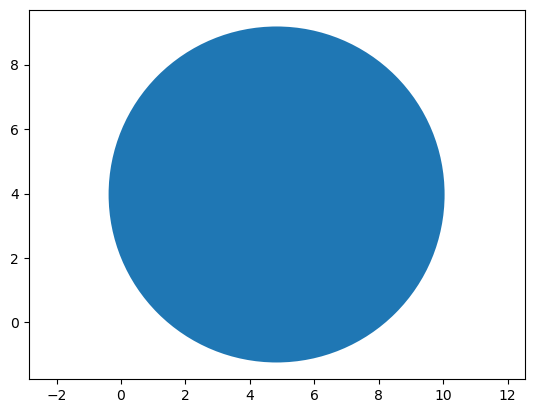

a:  4.8301056542974524365 b:  3.9699216766345842848 R:  5.2138243072360282554


In [33]:
from matplotlib import pyplot as plt, patches

fig = plt.figure()
ax = fig.add_subplot()
circle1 = patches.Circle((y[0], y[1]), radius=y[2])
ax.add_patch(circle1)
ax.axis('equal')
plt.show()
print("a: ", y[0], "b: ", y[1], "R: ", y[2])